In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

## Preparing Data

In [ ]:
left = pd.read_excel('/content/drive/My Drive/msml 602/left.xlsx')
right = pd.read_excel('/content/drive/My Drive/msml 602/right.xlsx')

In [ ]:
left

,titles,sources
0,Gretchen Whitmer Rebukes Trump In Powerful Ess...,HuffPost
1,Ted Cruz On Trump's Hunter Biden Obsession: It...,HuffPost
2,Trump Faces COVID-19 Surge In Critical Midwest...,HuffPost
3,Trump Plans Battleground Blitz Despite Growing...,HuffPost
4,Trump Campaign Takes Biden's Pope Francis Quot...,HuffPost
...,...,...
76,Trump's Hunt for Red October,Palmer Report
77,The Despicable Trump Legacy,Palmer Report
78,Donald Trump Has a Whole New Twitter Problem,Palmer Report
79,Donald Trump Is Crashing and Burning,Palmer Report


In [ ]:
right

,titles,sources
0,Kamala Harris Bursts out Laughing When Asked I...,FOX News
1,Russia's Putin Appears to Defend Hunter Biden ...,FOX News
2,"Gerard Baker: If Biden, Dems Win, Will America...",FOX News
3,Bloomberg Super PAC Outspending Trump in Ohio ...,FOX News
4,Trump Says Biden Would 'Tie the Hands of Every...,FOX News
...,...,...
77,Hemingway And Harsanyi: Is Trump's Record Enou...,The Federalist
78,"Like So Many Conservatives, The New York Post ...",The Federalist
79,New York Times Poll: Trump Expands Lead In Texas,The Federalist
80,7 Leftist Threats Political Terror Is Coming W...,The Federalist


In [ ]:
#using stopwords method to denoise the data

nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
left['titles']=left['titles'].apply(denoise_text)
right['titles']=right['titles'].apply(denoise_text)

## Plotting wordclouds and ngrams

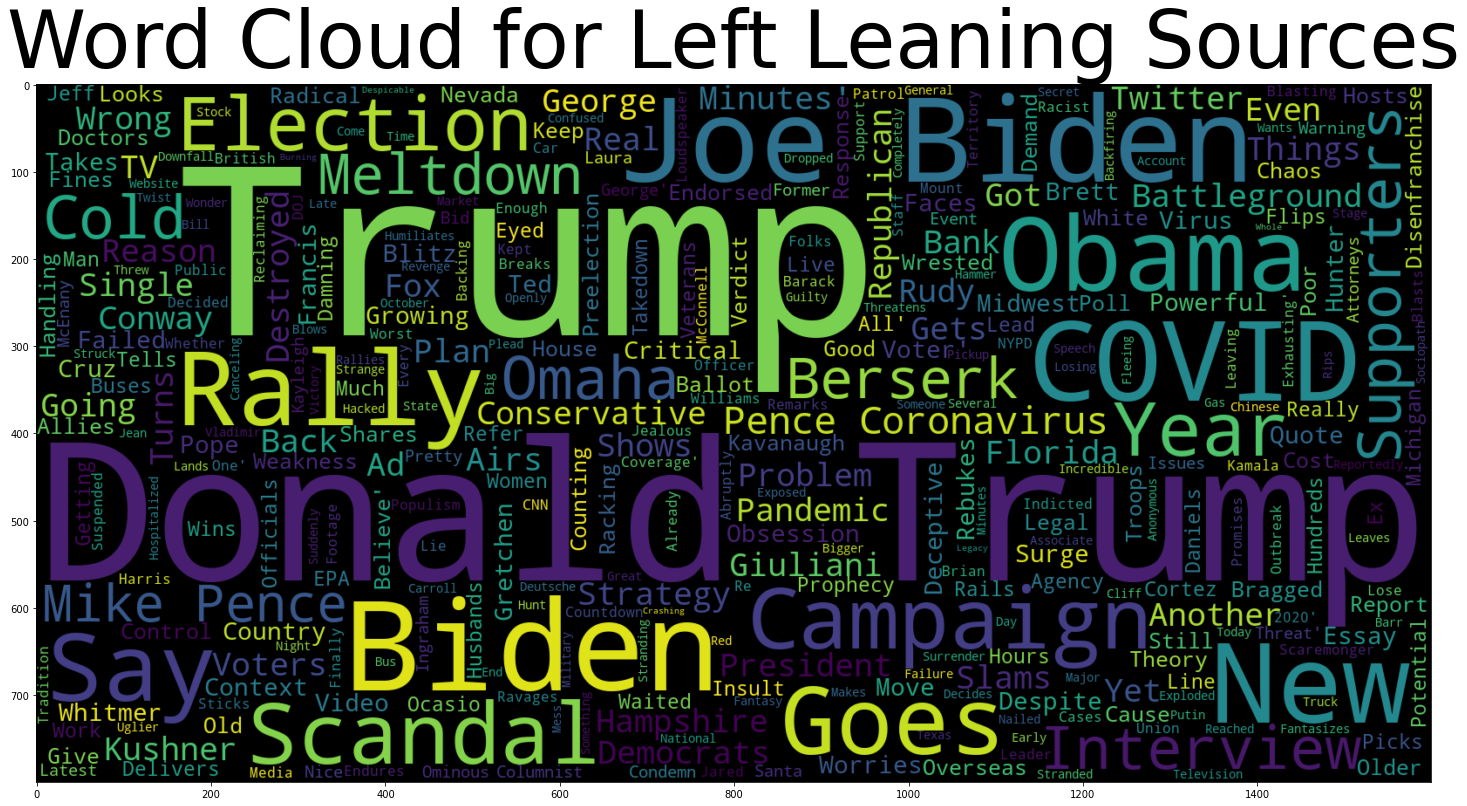

In [ ]:
plt.figure(figsize = (25,25)) 
plt.title('Word Cloud for Left Leaning Sources',fontsize=80)
wc_left = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(left['titles']))
plt.imshow(wc_left , interpolation = 'bilinear')

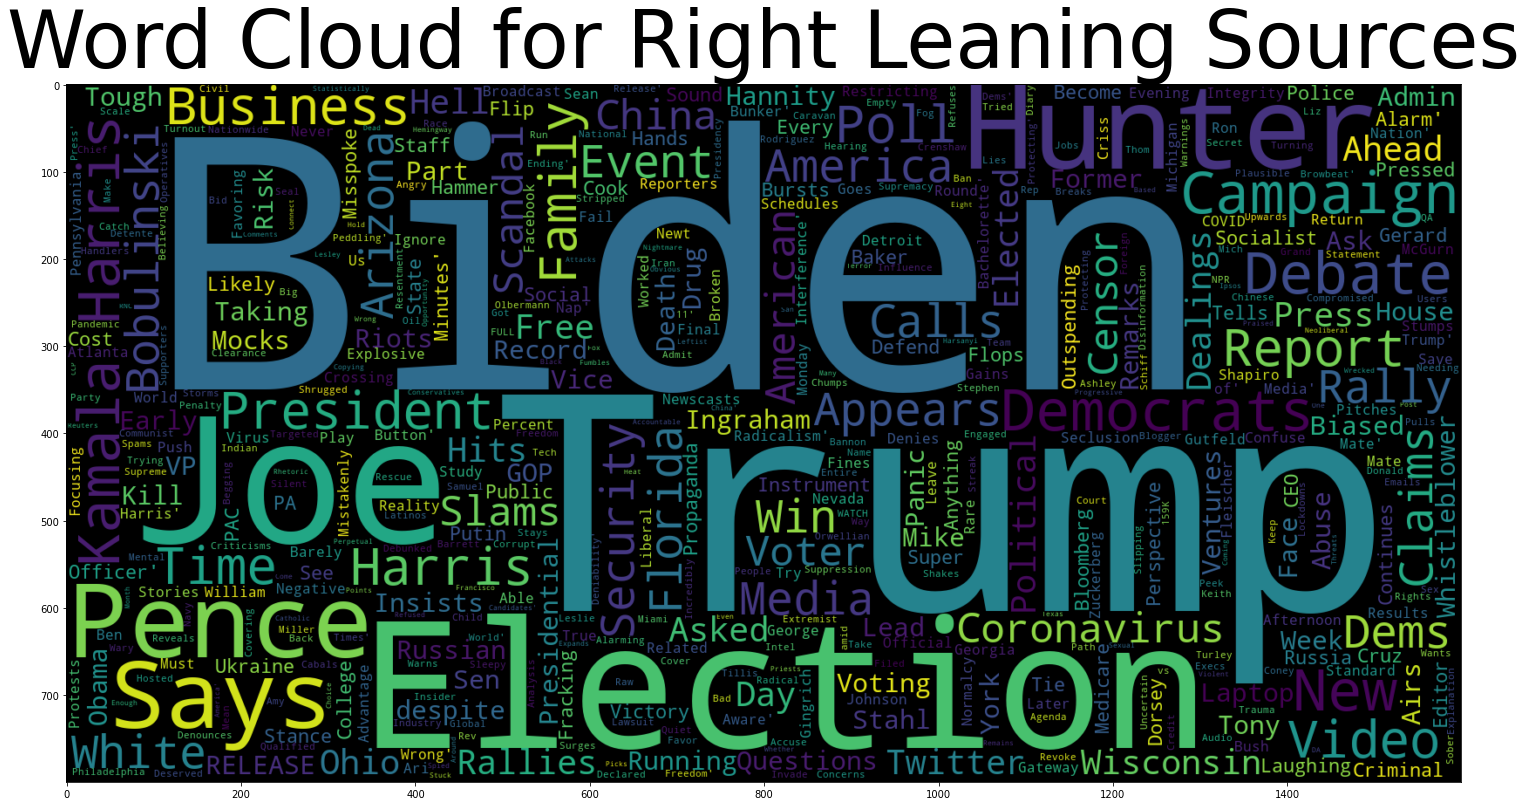

In [ ]:
plt.figure(figsize = (25,25))
plt.title('Word Cloud for Right Leaning Sources',fontsize=80)
wc_right = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(right['titles']))
plt.imshow(wc_right , interpolation = 'bilinear')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus_left = get_corpus(left['titles'])
corpus_right = get_corpus(right['titles'])

In [ ]:
from collections import Counter

counter_left = Counter(corpus_left)
counter_right = Counter(corpus_right)


In [ ]:
most_common_left = counter_left.most_common(15)
most_common_left = dict(most_common_left)
most_common_left

{'--': 3,
 'Biden': 14,
 'COVID-19': 5,
 'Campaign': 4,
 'Donald': 31,
 'Goes': 5,
 "He's": 3,
 'Interview': 3,
 'Joe': 8,
 'New': 5,
 'Obama': 4,
 'Rally': 5,
 'Supporters': 3,
 'Trump': 44,
 "Trump's": 14}

In [ ]:
most_common_right = counter_right.most_common(15)
most_common_right = dict(most_common_right)
most_common_right

{'2020': 4,
 'Biden': 41,
 "Biden's": 6,
 'Business': 4,
 'Debate': 4,
 'Democrats': 5,
 'Election': 6,
 'Harris': 5,
 'Hunter': 4,
 'Joe': 7,
 'Kamala': 5,
 'New': 4,
 'President': 4,
 'Says': 5,
 'Trump': 34}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0.5, 1.0, 'Bigram Analysis for Left Leaning Sources')

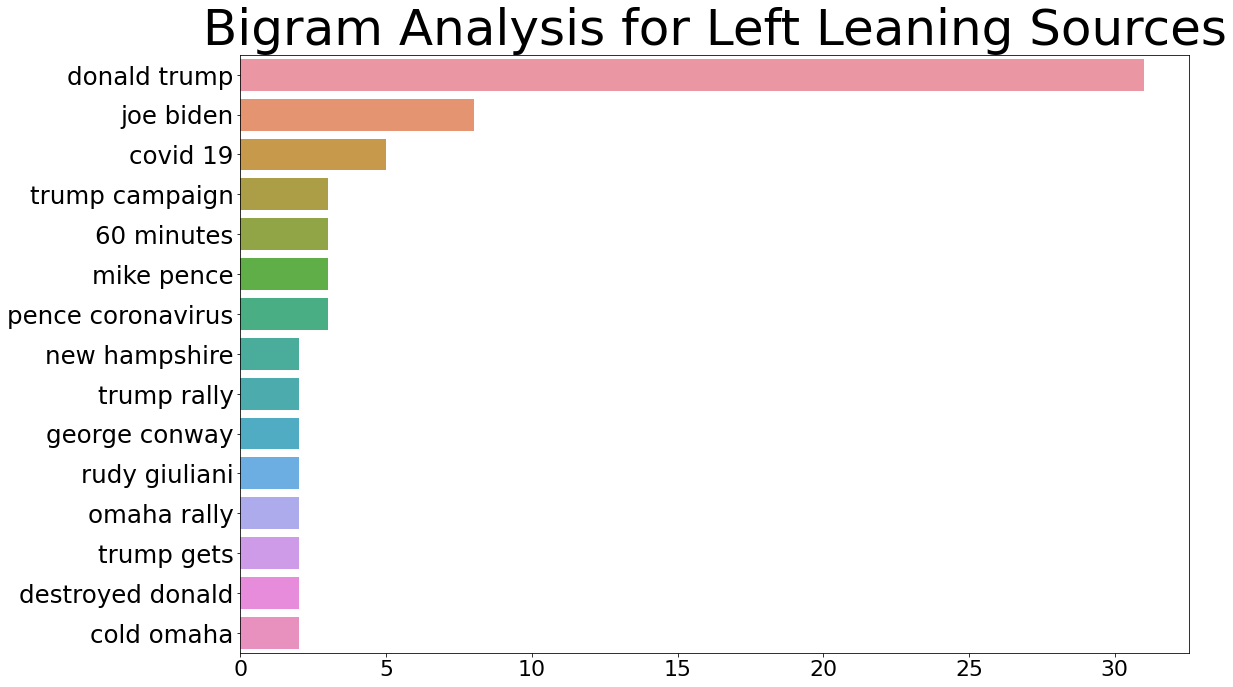

In [ ]:
plt.figure(figsize = (17,11))
most_common_bi_left = get_top_text_ngrams(left.titles,15,2)
most_common_bi_left = dict(most_common_bi_left)
sns.barplot(x=list(most_common_bi_left.values()),y=list(most_common_bi_left.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Bigram Analysis for Left Leaning Sources', fontsize=50)

Text(0.5, 1.0, 'Trigram Analysis for Left Leaning Sources')

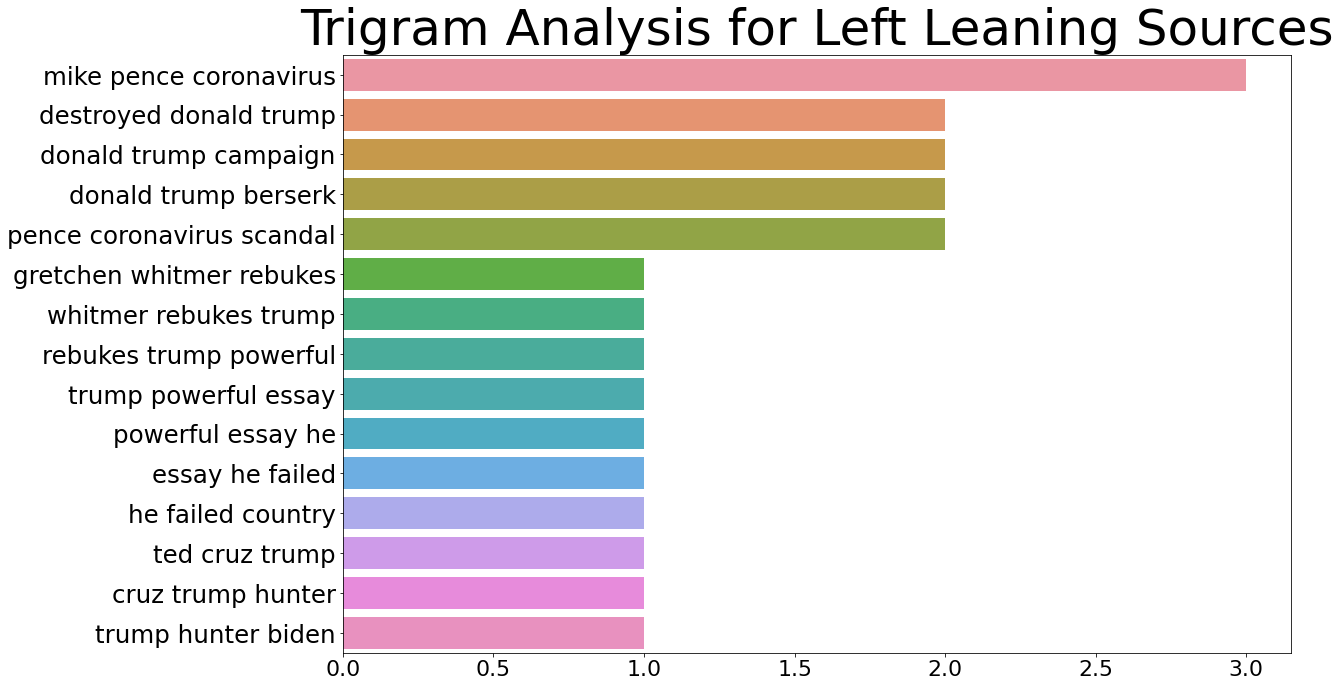

In [ ]:
plt.figure(figsize = (17,11))
most_common_tri_left = get_top_text_ngrams(left.titles,15,3)
most_common_tri_left = dict(most_common_tri_left)
sns.barplot(x=list(most_common_tri_left.values()),y=list(most_common_tri_left.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Trigram Analysis for Left Leaning Sources', fontsize=50)

Text(0.5, 1.0, 'Four-gram Analysis for Left Leaning Sources')

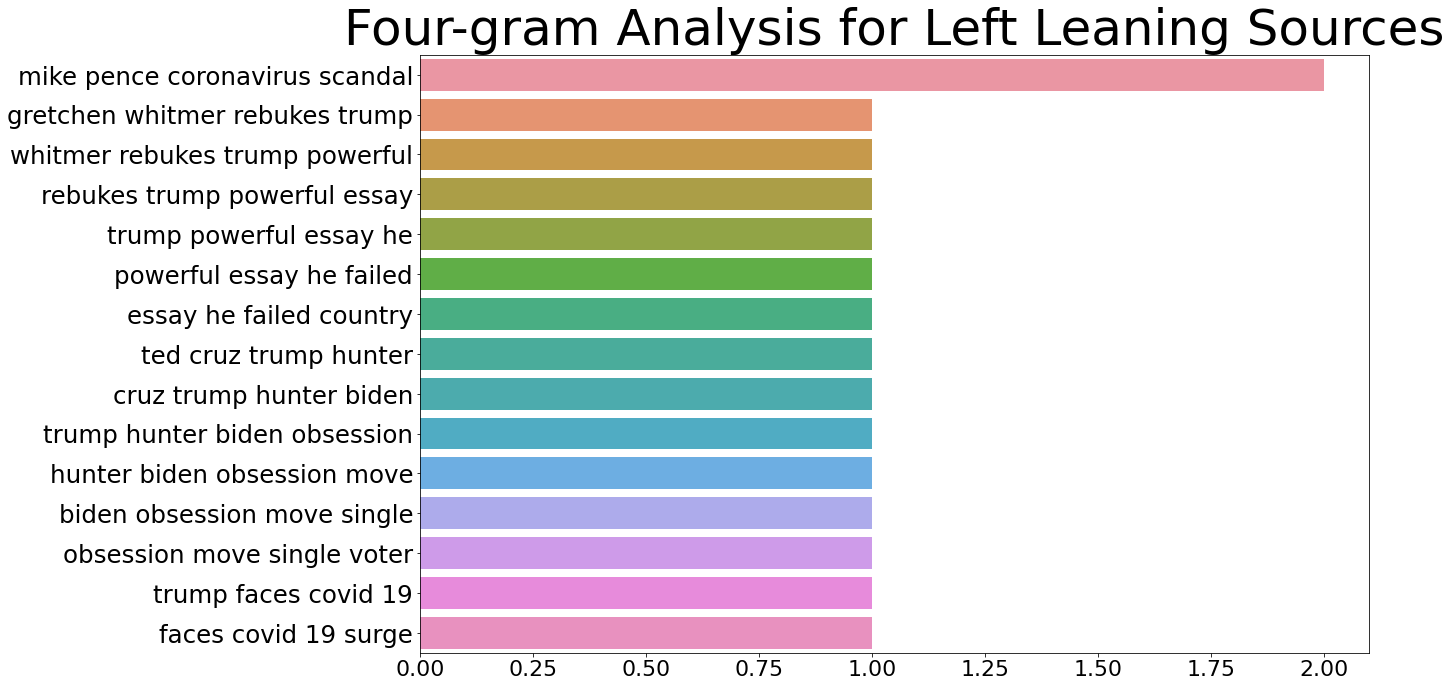

In [ ]:
plt.figure(figsize = (17,11))
most_common_fo_left = get_top_text_ngrams(left.titles,15,4)
most_common_fo_left = dict(most_common_fo_left)
sns.barplot(x=list(most_common_fo_left.values()),y=list(most_common_fo_left.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Four-gram Analysis for Left Leaning Sources', fontsize=50)

Text(0.5, 1.0, 'Bigram Analysis for Right Leaning Sources')

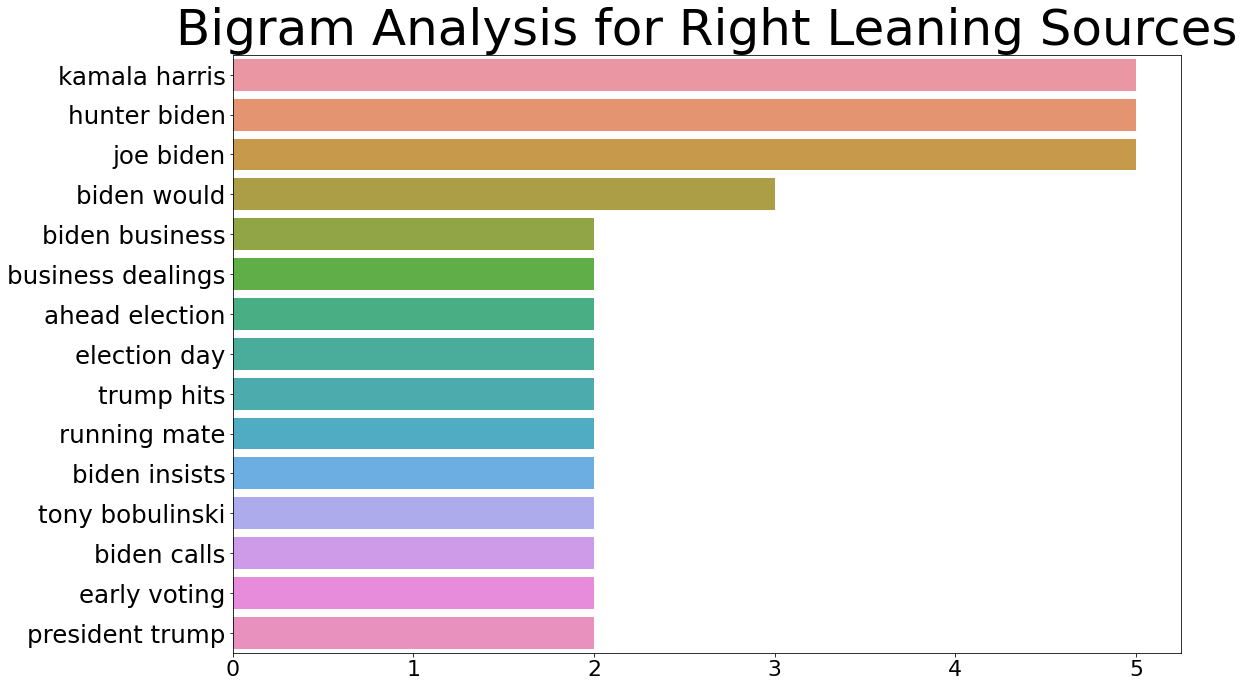

In [ ]:
plt.figure(figsize = (17,11))
most_common_bi_right = get_top_text_ngrams(right.titles,15,2)
most_common_bi_right = dict(most_common_bi_right)
sns.barplot(x=list(most_common_bi_right.values()),y=list(most_common_bi_right.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Bigram Analysis for Right Leaning Sources', fontsize=50)

Text(0.5, 1.0, 'Trigram Analysis for Right Leaning Sources')

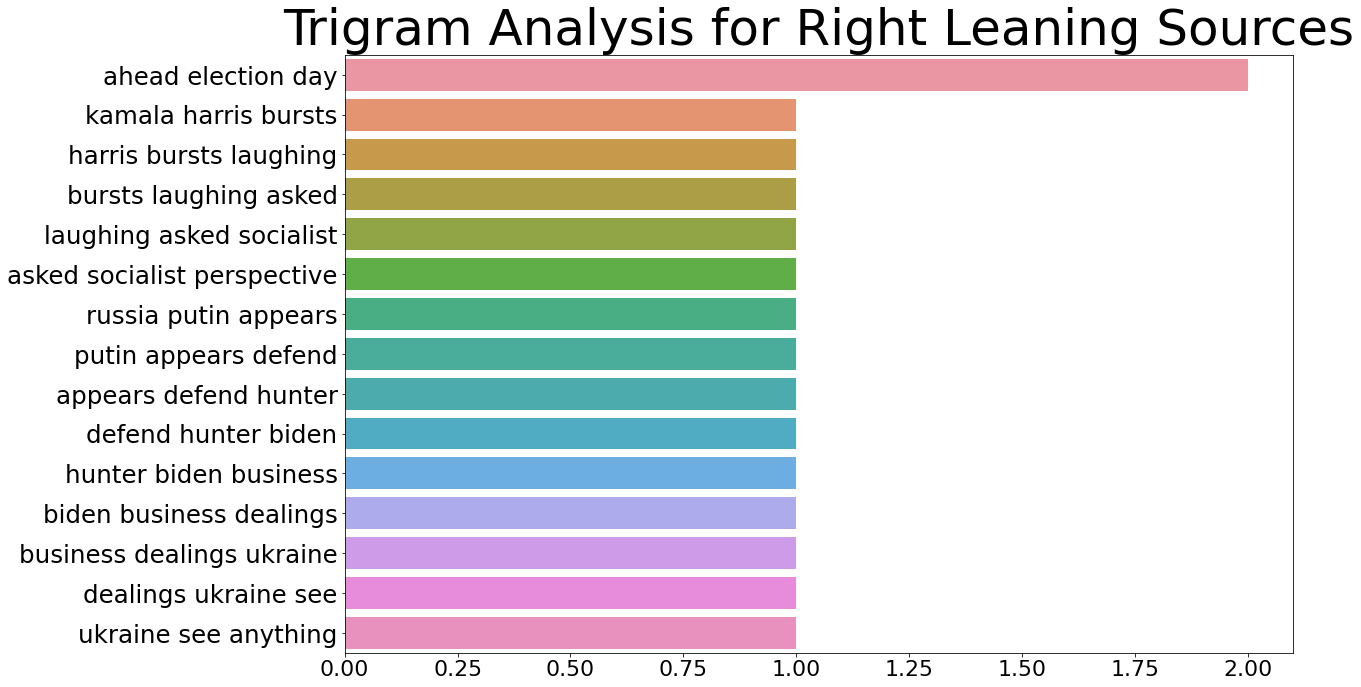

In [ ]:
plt.figure(figsize = (17,11))
most_common_tri_right = get_top_text_ngrams(right.titles,15,3)
most_common_tri_right = dict(most_common_tri_right)
sns.barplot(x=list(most_common_tri_right.values()),y=list(most_common_tri_right.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Trigram Analysis for Right Leaning Sources', fontsize=50)

Text(0.5, 1.0, 'Four-gram Analysis for Right Leaning Sources')

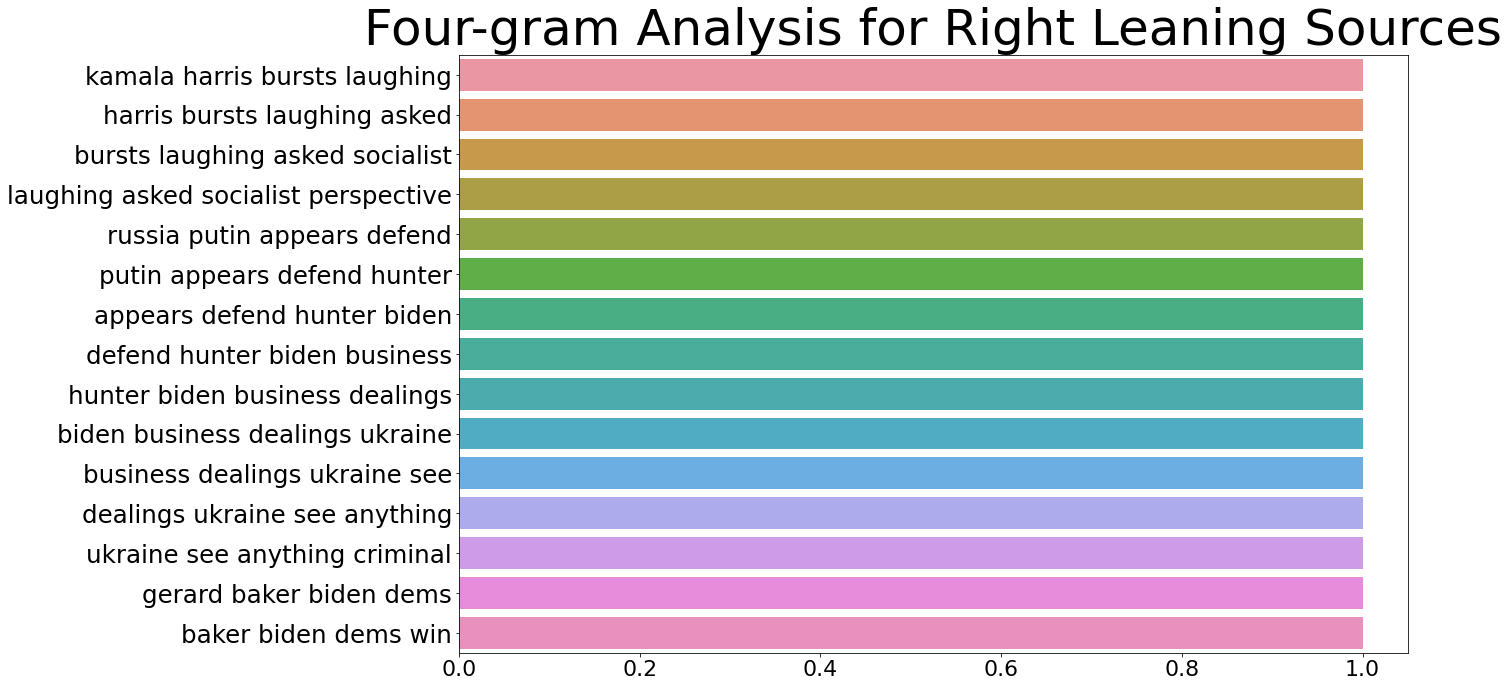

In [ ]:
plt.figure(figsize = (17,11))
most_common_fo_right = get_top_text_ngrams(right.titles,15,4)
most_common_fo_right = dict(most_common_fo_right)
sns.barplot(x=list(most_common_fo_right.values()),y=list(most_common_fo_right.keys()))
plt.xticks(fontsize=22)
plt.yticks(fontsize=24.5)
plt.title('Four-gram Analysis for Right Leaning Sources', fontsize=50)

## Reformating the data in preparation for it to be trained

In [ ]:
left['bias'] = 'left' # adding a column indicating the bias of the articles

left

,titles,sources,bias
0,Gretchen Whitmer Rebukes Trump Powerful Essay:...,HuffPost,left
1,Ted Cruz Trump's Hunter Biden Obsession: Move ...,HuffPost,left
2,Trump Faces COVID-19 Surge Critical Midwest Ba...,HuffPost,left
3,Trump Plans Battleground Blitz Despite Growing...,HuffPost,left
4,Trump Campaign Takes Biden's Pope Francis Quot...,HuffPost,left
...,...,...,...
76,Trump's Hunt Red October,Palmer Report,left
77,Despicable Trump Legacy,Palmer Report,left
78,Donald Trump Whole New Twitter Problem,Palmer Report,left
79,Donald Trump Crashing Burning,Palmer Report,left


In [ ]:
right['bias'] = 'right' # adding a column indicating the bias of the articles

right

,titles,sources,bias
0,Kamala Harris Bursts Laughing Asked Socialist ...,FOX News,right
1,Russia's Putin Appears Defend Hunter Biden Bus...,FOX News,right
2,"Gerard Baker: Biden, Dems Win, America's Free ...",FOX News,right
3,Bloomberg Super PAC Outspending Trump Ohio Ahe...,FOX News,right
4,Trump Says Biden Would 'Tie Hands Every Police...,FOX News,right
...,...,...,...
77,Hemingway Harsanyi: Trump's Record Enough Win ...,The Federalist,right
78,"Like Many Conservatives, New York Post Come Ar...",The Federalist,right
79,New York Times Poll: Trump Expands Lead Texas,The Federalist,right
80,7 Leftist Threats Political Terror Coming Whet...,The Federalist,right


In [ ]:
df = pd.concat([left,right],axis=0) #stacking the two dataframes toghether
df = df.sample(frac = 1) #shuffling the data for it to be in a ramdom stage

df

,titles,sources,bias
7,Trump's Ballot-Counting Demand Would Disenfran...,HuffPost,left
11,Trump Rally Hosts Keep Racking COVID-19 Fines ...,HuffPost,left
39,Ingraham: Americans 'Stripped Freedom' Biden P...,FOX News,right
43,Biden Laptop Hell,Infowars,right
30,Joe Biden Could Compromised Chinese Communist ...,FOX News,right
...,...,...,...
60,Analysis: Biden Would Face Uncertain Path Dete...,OAN,right
50,Extremist Democrats Take Part Event Hosted Blo...,Infowars,right
7,"Trump Hits Biden Social Security, Medicare Fli...",FOX News,right
16,Gutfeld Trump's Rallies Biden's Seclusion,FOX News,right


In [ ]:
#setting up the X and Y values
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
features = ["phrase #1","phrase #2","phrase #3","phrase #4","phrase #5","phrase #6","phrase #7",
            "phrase #8","phrase #9","phrase #10","phrase #11","phrase #12","phrase #13",
            "phrase #14","phrase #15"]

### ***Unigram* Decision Tree w/ Confusion Matrix and Cross Validation**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv_title = CountVectorizer(max_features=15)
mat_title = cv_title.fit_transform(X[:,0]).todense()

In [ ]:
mat_title

matrix([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
mat_title.shape

(163, 15)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mat_title,y, test_size=0.25, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier_dtr = DecisionTreeClassifier(criterion='entropy')
classifier_dtr.fit(X_train, y_train)
y_pred_dtr = classifier_dtr.predict(X_test)

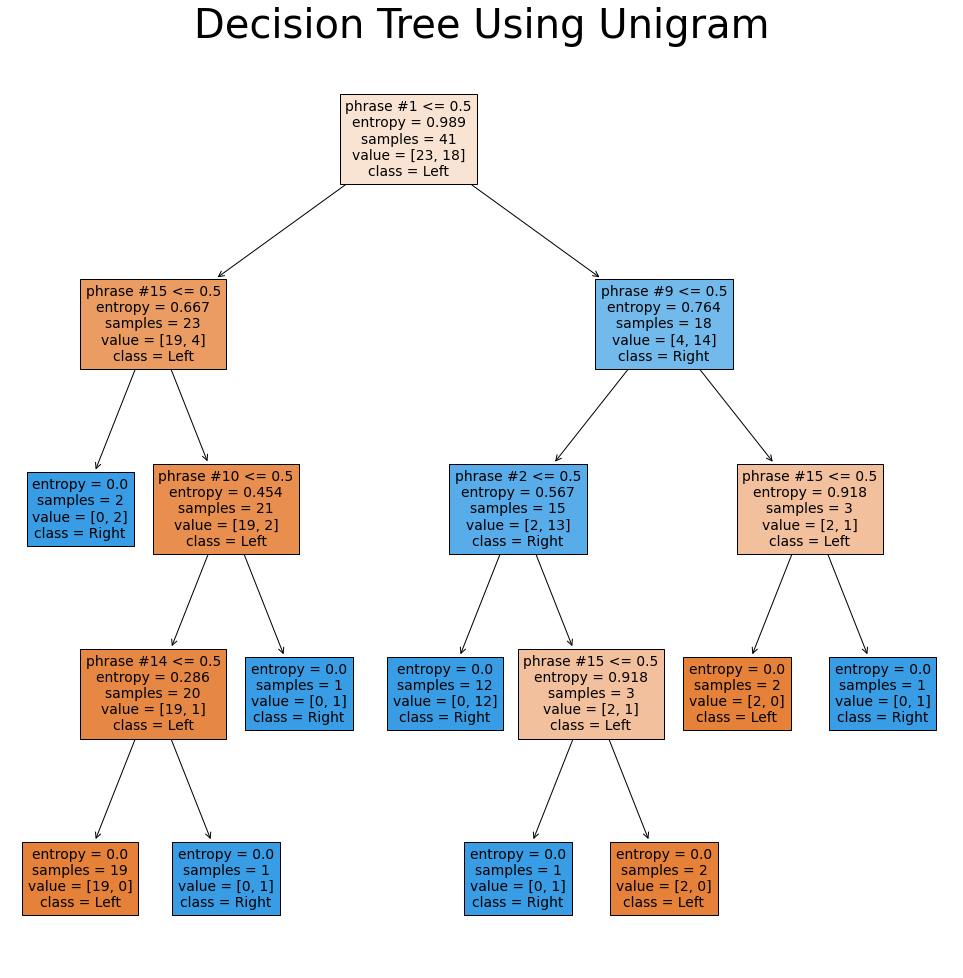

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(17,17))
clf = DecisionTreeClassifier(criterion='entropy').fit(X_test,y_pred_dtr)
plot_tree(clf,class_names=["Left","Right"],feature_names=features,filled=True)
plt.title('Decision Tree Using Unigram', fontsize=40)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_dtr)

Text(0.5, 1.0, 'Confusion Matrix, Unigram')

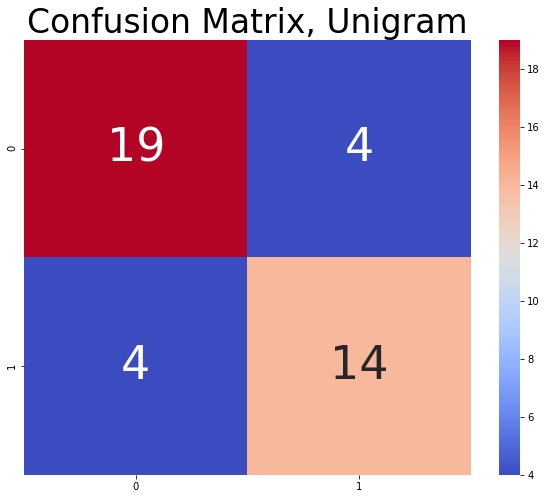

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,cmap='coolwarm',annot=True,annot_kws={'size':46})
plt.title('Confusion Matrix, Unigram',fontsize=33)

In [ ]:
clf.score(X_test,y_test)

0.8048780487804879

In [ ]:
from sklearn.model_selection import cross_val_score

k =4

scores = cross_val_score(classifier_dtr, mat_title, y, cv=k)

scores

array([0.70731707, 0.70731707, 0.82926829, 0.725     ])

In [ ]:
average_scores = np.mean(scores)
std_scores = np.std(scores)
uncertainty = (2*std_scores)/(np.sqrt(k))

print('The corss validated accuracy of the unigram model w/ uncertainty is',average_scores,'+ or -',uncertainty)

The corss validated accuracy of the unigram model w/ uncertainty is 0.7422256097560975 + or - 0.05076997669793032


### ***Bigram* Decision Tree w/ Confusion Matrix and cross validation**

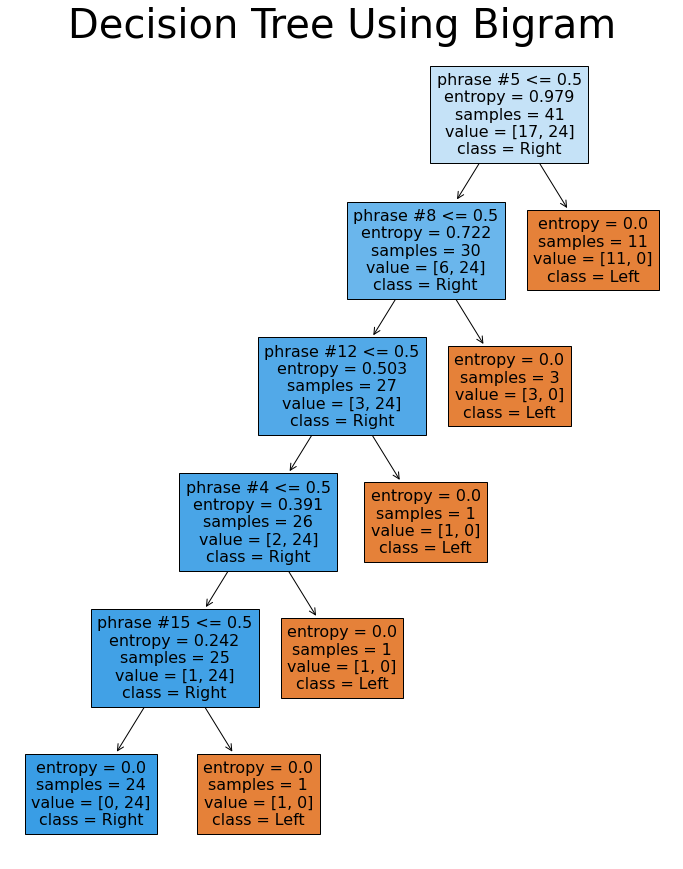

In [ ]:
#bigram decision tree

bi_cv_title = CountVectorizer(ngram_range=(2,2),max_features=15)
bi_mat_title = bi_cv_title.fit_transform(X[:,0]).todense()

X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(bi_mat_title,y, 
                                                                test_size=0.25, 
                                                                random_state=0)

classifier_dtr_bi = DecisionTreeClassifier(criterion='entropy')
classifier_dtr_bi.fit(X_train_bi, y_train_bi)
y_pred_dtr_bi = classifier_dtr_bi.predict(X_test_bi)

plt.figure(figsize=(12,15))
clf_bi = DecisionTreeClassifier(criterion='entropy').fit(X_test_bi,y_pred_dtr_bi)
plot_tree(clf_bi,class_names=["Left","Right"],feature_names=features, filled=True)
plt.title('Decision Tree Using Bigram', fontsize=40)
plt.show()

Text(0.5, 1.0, 'Confusion Matrix, Bigram')

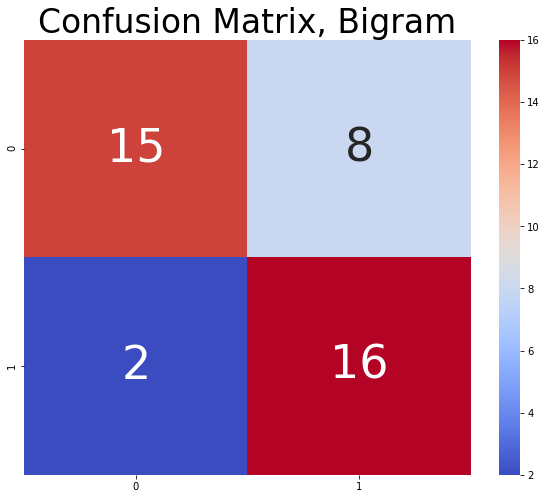

In [ ]:
cm_bi = confusion_matrix(y_test_bi, y_pred_dtr_bi)

plt.figure(figsize=(10,8))
sns.heatmap(cm_bi,cmap='coolwarm',annot=True,annot_kws={'size':46})
plt.title('Confusion Matrix, Bigram',fontsize=33)

In [ ]:
clf_bi.score(X_test_bi,y_test_bi)

0.7560975609756098

In [ ]:
from sklearn.model_selection import cross_val_score

scores_bi = cross_val_score(classifier_dtr, bi_mat_title, y, cv=4)

scores_bi

array([0.6097561 , 0.7804878 , 0.65853659, 0.775     ])

In [ ]:
bi_average_scores = np.mean(scores_bi)
bi_std_scores = np.std(scores_bi)
bi_uncertainty = (2*bi_std_scores)/(np.sqrt(k))

print('The corss validated accuracy of the bigram model w/ uncertainty is',bi_average_scores,'+ or -',bi_uncertainty)

The corss validated accuracy of the bigram model w/ uncertainty is 0.7059451219512195 + or - 0.07386657822482146


## Refitting the decision trees using the entire pre-test-train-split data set

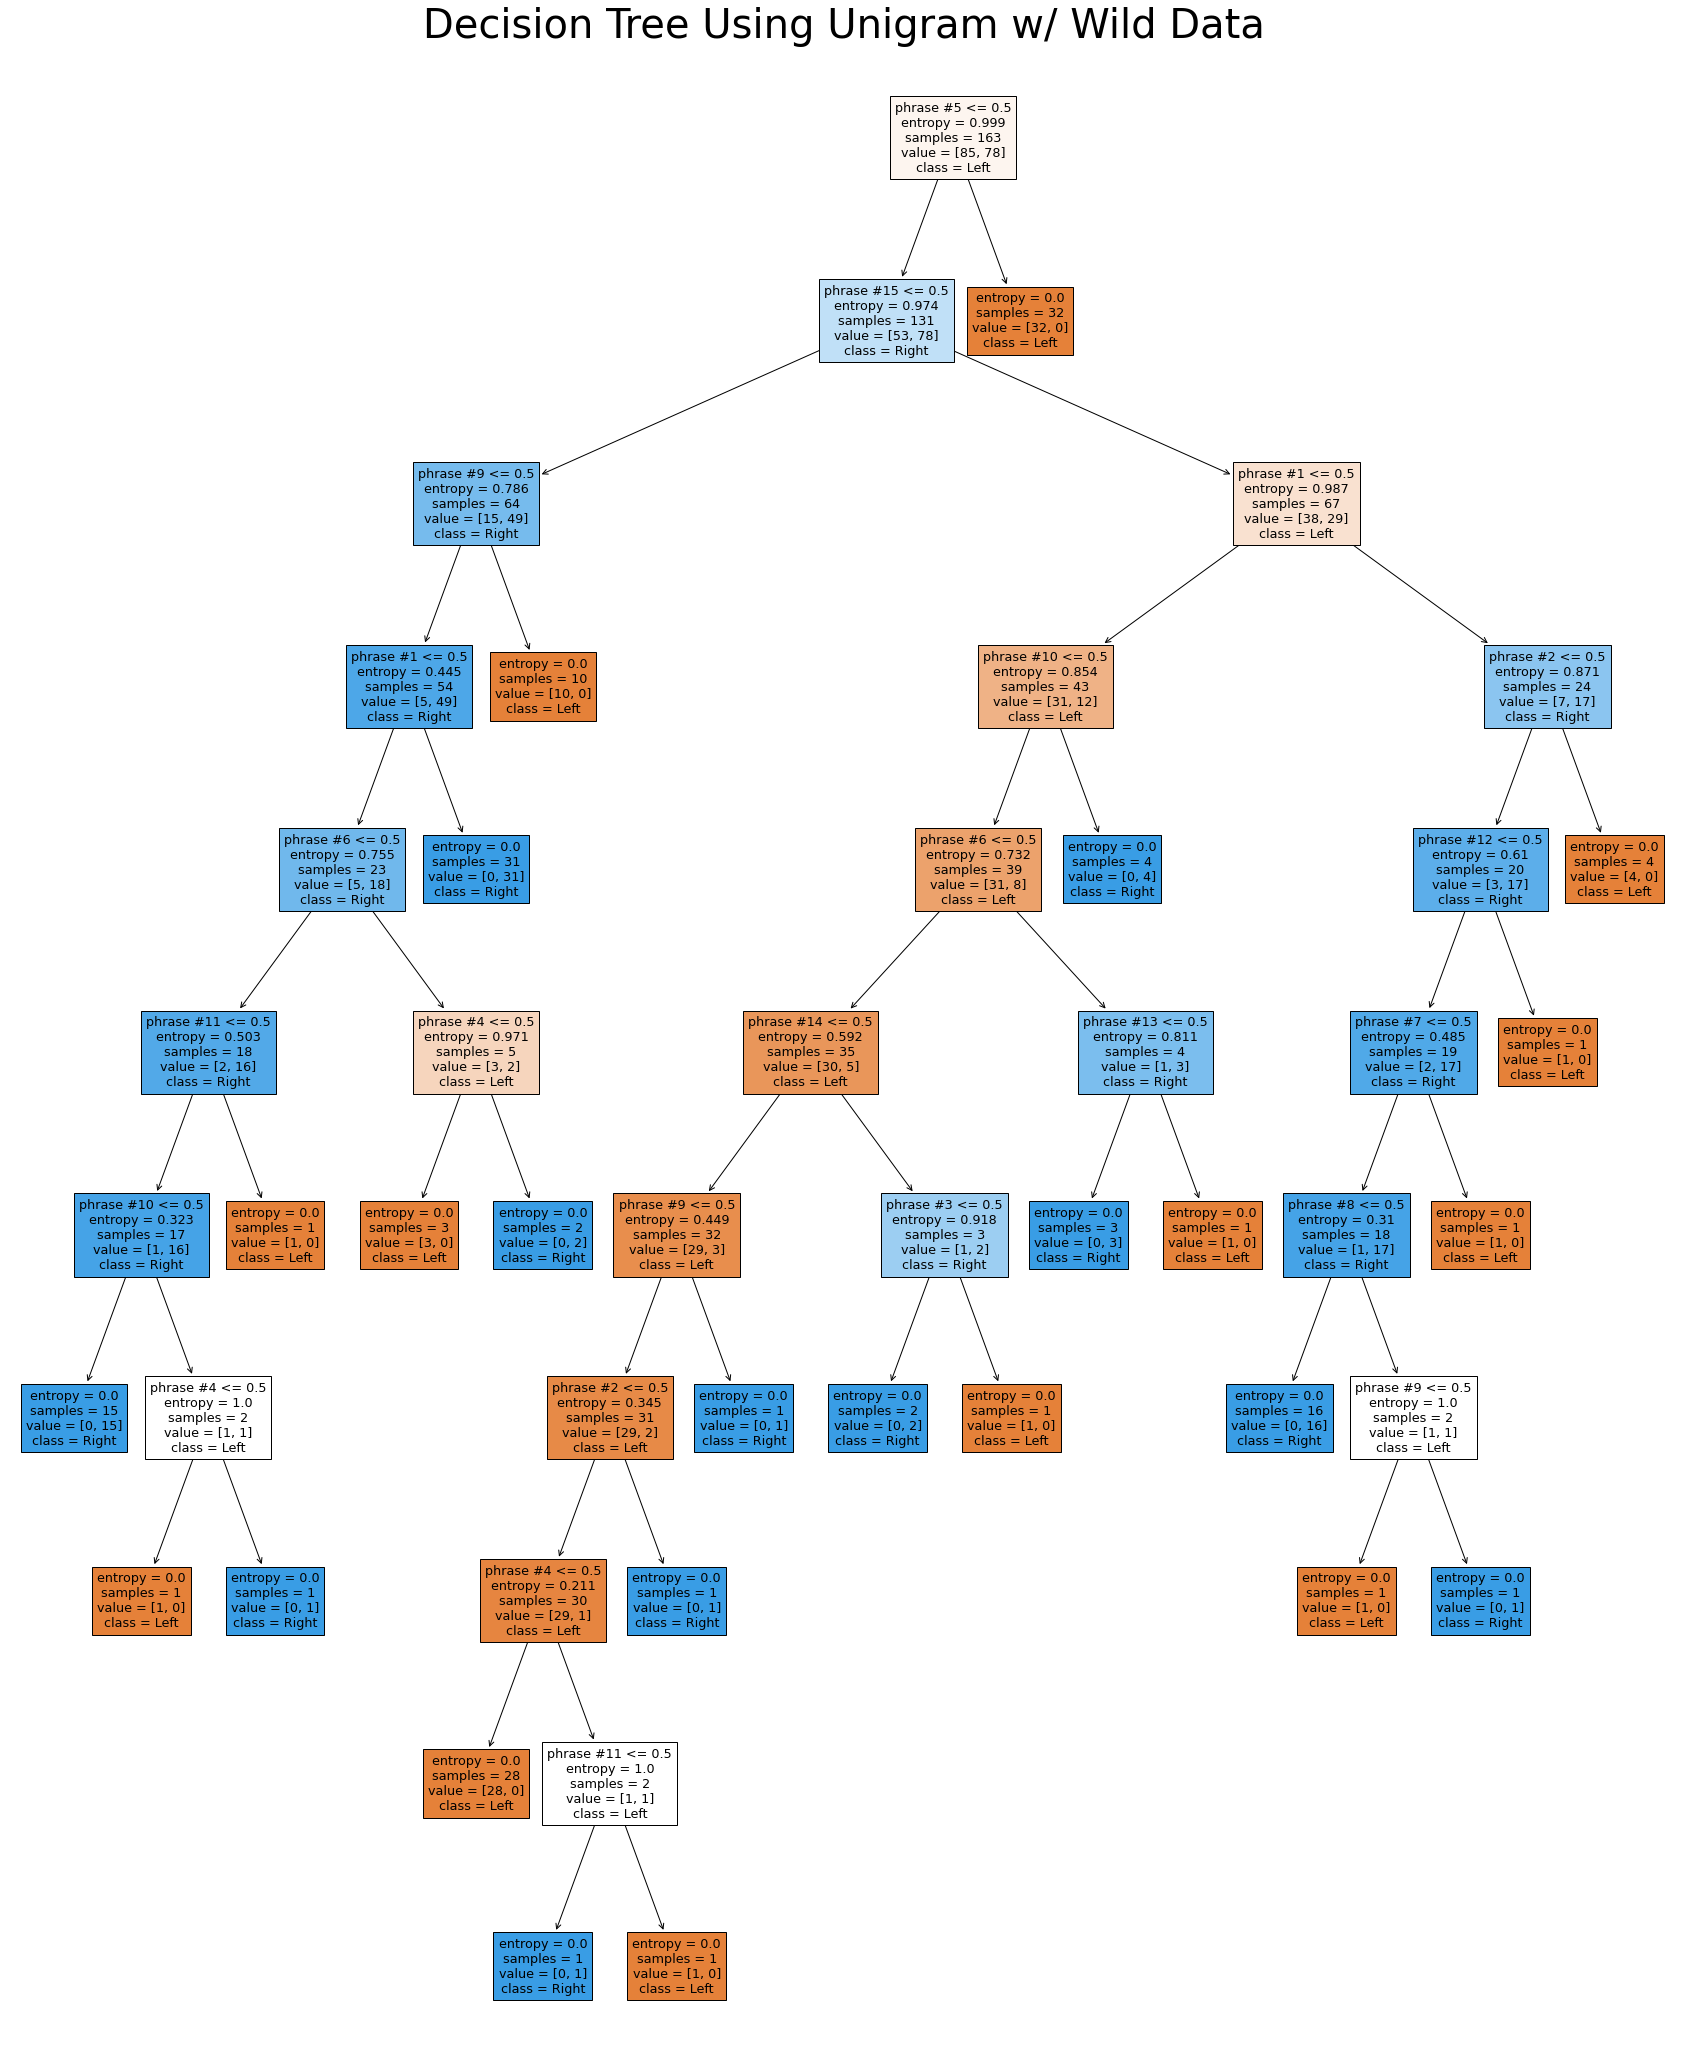

In [ ]:
y_vali_dtr = classifier_dtr.predict(mat_title)

plt.figure(figsize=(30,37))
clf_vali = DecisionTreeClassifier(criterion='entropy').fit(mat_title,y_vali_dtr)
plot_tree(clf_vali,class_names=["Left","Right"],feature_names=features, filled=True)
plt.title('Decision Tree Using Unigram w/ Wild Data', fontsize=40)
plt.show()

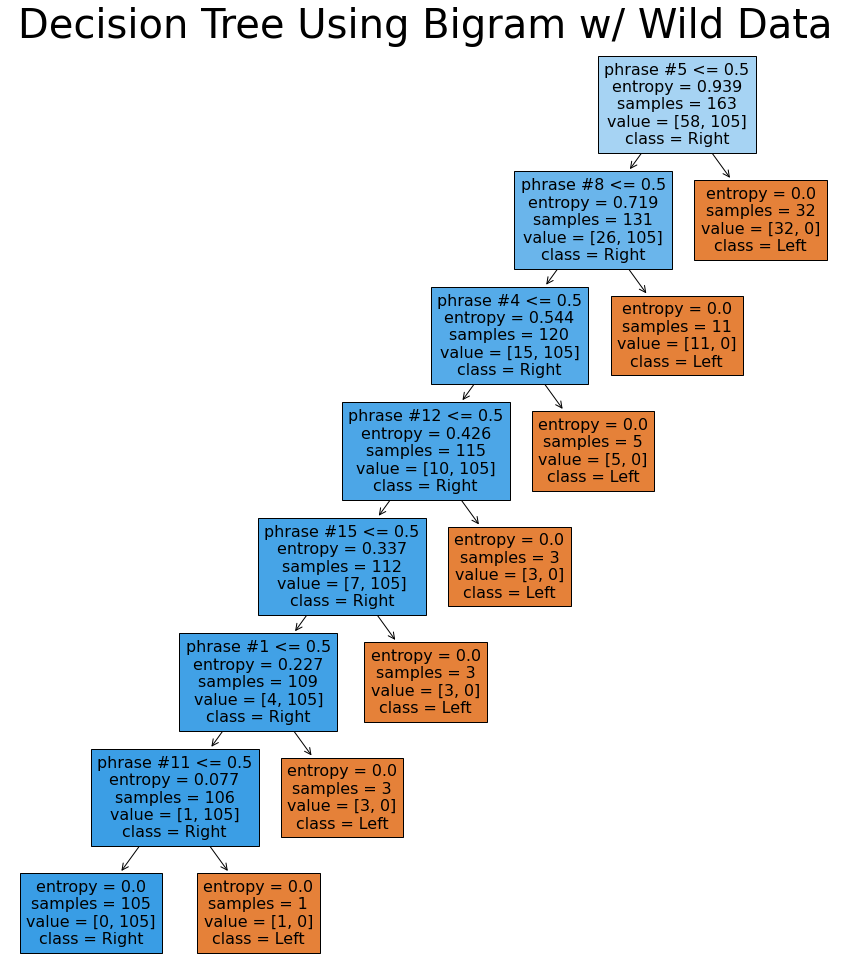

In [ ]:
y_vali_dtr_bi = classifier_dtr_bi.predict(bi_mat_title)

plt.figure(figsize=(15,17))
clf_vali_bi = DecisionTreeClassifier(criterion='entropy').fit(bi_mat_title,y_vali_dtr_bi)
plot_tree(clf_vali_bi,class_names=["Left","Right"], feature_names=features,filled=True)
plt.title('Decision Tree Using Bigram w/ Wild Data', fontsize=40)
plt.show()

### Now I am applying the bigram model onto some articles from known biased sources. These articles are not included in the dataframe used for training and testing my models. 

In [ ]:
df_vali = pd.read_excel('/content/drive/My Drive/msml 602/reserved.xlsx')
df_vali['titles']=df_vali['titles'].apply(denoise_text)

df_vali

,titles,sources
0,Gov. Whitmer Completely Falls Apart Asked Hunt...,Red State (R)
1,Obama delivers fiery rebuke Trump; president r...,The Washington Post (L)


In [ ]:
X_vali = df_vali.iloc[:,0].values

vali_title = cv_title.fit_transform(X_vali).todense()

y_vali_dtr = classifier_dtr.predict(vali_title)

print(y_vali_dtr)
print(average_scores,'+ or -',uncertainty)

['right' 'left']
0.7422256097560975 + or - 0.05076997669793032


In [ ]:
vali_title_bi = bi_cv_title.fit_transform(X_vali).todense()

y_vali_dtr_bi = classifier_dtr_bi.predict(vali_title_bi)

print(y_vali_dtr_bi)

print(bi_average_scores,'+ or -',bi_uncertainty)

['left' 'left']
0.7059451219512195 + or - 0.07386657822482146
